In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

from gwr import GWR

from sel_bw import Sel_BW
from scipy import stats
from sklearn.preprocessing import StandardScaler


import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar

import seaborn as sns
sns.set(color_codes=True)

import warnings
warnings.filterwarnings('ignore')

scaler = StandardScaler()
%matplotlib inline



gsv = pd.read_csv('./data/summary_census_sep_30_2020.csv')  # Google streetview Data
pedf = pd.read_csv('./data/EPA_walk.csv')

california = gpd.read_file('./data/california tracts.zip')
alabama = gpd.read_file('./data/alabama tracts.zip')
massa = gpd.read_file('./data/massachusetts tracts.zip')

In [2]:
pedf['GEOID20'] = pedf['GEOID20'].astype('str')
pedf['GEOID20'] = [i[:-3] for i in pedf.GEOID20]
pedf['GEOID20'] = pedf['GEOID20'].astype('int64')
pedf = pd.DataFrame(pedf.groupby('GEOID20')['D3APO'].mean().reset_index())

In [3]:
def createCensus(state):
    state['GEOID'] = state['GEOID'].astype('int64')
    state = state.merge(pedf, left_on='GEOID', right_on='GEOID20', how='inner')
    state = state.merge(gsv, left_on='GEOID', right_on='GEOID', how='inner')
    state = state[['GEOID', 'geometry', 'D3APO', 'prop_crosswalk', 'prop_sidewalk' ]]
    state['lon'] = state['geometry'].centroid.x
    state['lat'] = state['geometry'].centroid.y
    
    return state

In [4]:
california = createCensus(california)

In [5]:
alabama = createCensus(alabama)

In [19]:
# alabama

,GEOID,geometry,D3APO,prop_crosswalk,prop_sidewalk,lon,lat,new_algo_params,gwr_calc
0,1055010700,"POLYGON ((-85.98699 34.04414, -85.98606 34.045...",2.145734,0.001807,0.018488,-85.893056,34.065090,0.678022,0.884709
1,1055001300,"POLYGON ((-86.00068 34.00537, -86.00023 34.006...",13.553538,0.055556,0.377628,-85.983253,34.007989,0.679815,0.853182
2,1055000900,"POLYGON ((-86.07079 34.00011, -86.07076 34.000...",13.614264,0.008040,0.158291,-86.043214,34.000290,0.680257,0.840057
3,1055001700,"POLYGON ((-85.96885 33.98825, -85.96884 33.988...",9.131982,0.007829,0.076722,-85.951839,33.982532,0.680368,0.863943
4,1055010501,"POLYGON ((-86.07352 33.90549, -86.07337 33.906...",5.338374,0.004176,0.064491,-86.029304,33.897931,0.683051,0.863581
...,...,...,...,...,...,...,...,...,...
1173,1069040600,"POLYGON ((-85.40641 31.22702, -85.40638 31.228...",21.242537,0.075995,0.452352,-85.399040,31.228097,0.758235,0.816179
1174,1077011101,"POLYGON ((-87.72427 34.84033, -87.72418 34.840...",0.068049,0.002137,0.077991,-87.700158,34.864700,0.665219,0.407209
1175,1077011802,"POLYGON ((-87.3768 34.8132, -87.37664 34.81407...",0.289281,0.002366,0.030363,-87.294829,34.812097,0.664901,0.775689
1176,1077011603,"POLYGON ((-87.61041 34.91473, -87.61028 34.915...",0.329349,0.001151,0.014006,-87.527635,34.901395,0.663860,0.465607


In [6]:
g_y = alabama['D3APO'].values.reshape((-1,1))
g_X = alabama[['prop_sidewalk']].values

g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)
g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)

u = alabama['lon']
v = alabama['lat']

g_coords = list(zip(u,v))

In [7]:
len(alabama)

1178

In [8]:
gwr_selector_o = Sel_BW(g_coords, g_y, g_X, )
gwr_bw_o = gwr_selector_o.search(bw_min=2)
print(gwr_bw_o)
gwr_results_o = GWR(g_coords, g_y, g_X, gwr_bw_o, constant=True).fit()
gwr_results_o.summary()

27.03
Model type                                                         Gaussian
Number of observations:                                                1178
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            591.885
Log-likelihood:                                                   -1266.124
AIC:                                                               2536.248
AICc:                                                              2538.268
BIC:                                                              -7724.285
R2:                                                                   0.498
Adj. R2:                                                              0.497

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- 

In [9]:
"""Local collinearity formula implementation. Extracted from MGWR codebase, line 1092, gwr.py, __author__ = Taylor Oshan"""

# x_scaled = scaler.fit_transform(x)
# y_scaled = scaler.fit_transform(y)


x_ = np.hstack((g_X, g_y))

def corr(cov):
    invsd = np.diag(1 / np.sqrt(np.diag(cov)))
    cors = np.dot(np.dot(invsd, cov), invsd)
    return cors

corr_mat = np.ndarray(shape=(len(x_), 1))


for i in range(len(x_)):
    wi_ = gwr_results_o.model._build_wi(i, gwr_bw_o)
    sw = np.sum(wi_)
    wi_ = wi_/sw
    corr_mat[i] = corr(np.cov(x_[:, 0], x_[:, 1], aweights=wi_))[0][1]
    
corr_mat.mean(), corr_mat.min(), corr_mat.max()


# (0.5781829399414862, -0.33187579309574566, 0.9783015285481158)

(np.float64(0.5781829399414862),
 np.float64(-0.33187579309574566),
 np.float64(0.9783015285481156))

In [10]:
g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)
g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)

corr_coef, _ = stats.pearsonr(g_X.flatten(), g_y.flatten())

corr_coef

np.float64(0.7053729602566265)

In [11]:
# alabama['gwr_calc'] = corr_mat

In [12]:
g_y = alabama['D3APO'].values.reshape((-1,1))
g_X = alabama[['prop_sidewalk']].values

# g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)
# g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)

u = alabama['lon']
v = alabama['lat']

g_coords = list(zip(u,v))

In [13]:
%%time

gwr_selector_n = Sel_BW(g_coords, g_y, g_X, lwcc=True)
gwr_bw_n = gwr_selector_n.search(bw_min=2)
print(gwr_bw_n)
gwr_results_n = GWR(g_coords, g_y, g_X, gwr_bw_n, constant=False, lwcc=True).fit()
gwr_results_n.summary()

1177.14
Model type                                                         Gaussian
Number of observations:                                                1178
Number of covariates:                                                     1

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                          25047.743
Log-likelihood:                                                   -3472.062
AIC:                                                               6946.125
AICc:                                                              6948.135
BIC:                                                              16724.501
R2:                                                                   0.486
Adj. R2:                                                              0.486

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------

In [14]:
# g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)
# g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)

x_ = np.hstack((g_X, g_y))

def corr(cov):
    invsd = np.diag(1 / np.sqrt(np.diag(cov)))
    cors = np.dot(np.dot(invsd, cov), invsd)
    return cors

corr_mat = np.ndarray(shape=(len(x_), 1))


for i in range(len(x_)):
    wi_ = gwr_results_n.model._build_wi(i, 27)
    sw = np.sum(wi_)
    wi_ = wi_/sw
    corr_mat[i] = corr(np.cov(x_[:, 1], x_[:, 0], aweights=wi_))[0][1]
    
corr_mat.mean(), corr_mat.min(), corr_mat.max()

(np.float64(0.5781829399414862),
 np.float64(-0.3318757930957456),
 np.float64(0.9783015285481156))

In [15]:
alabama['new_algo_params'] = gwr_results_n.params
alabama['gwr_calc'] = corr_mat

In [16]:
# alabama

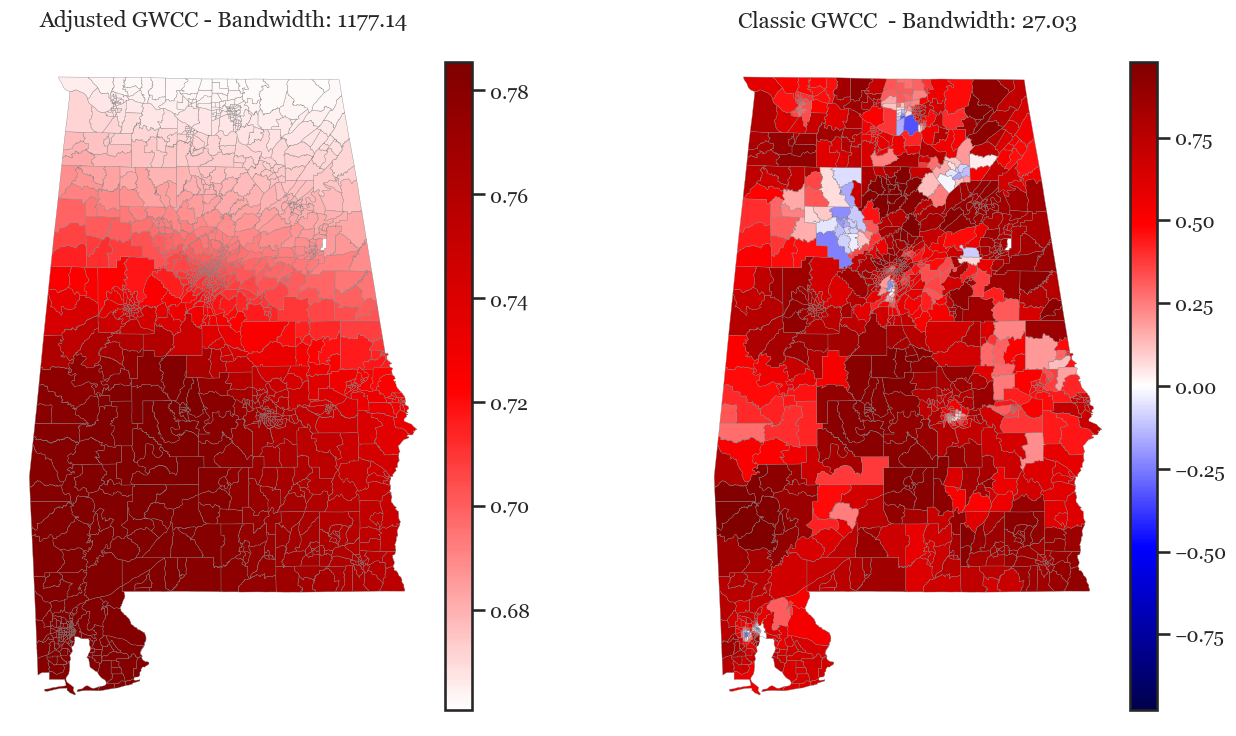

In [17]:
from utils import compare_surfaces

compare_surfaces(alabama, 'new_algo_params', 'gwr_calc', gwr_bw_n, gwr_bw_o, savefig=None)

In [18]:
corr = []

for i in range(len(g_X)):
    corr_coef, _ = stats.pearsonr(g_X.flatten(), g_y.flatten())
    corr.append(corr_coef)

np.array(corr).mean()

np.float64(0.7053729602566268)